# Importing Libraries

In [1]:
from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import json
import sys
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import seaborn as sns
from pandas.api.types import CategoricalDtype

# Importing Data

In [10]:
# Reading JSON Streaming History
df0 = pd.read_json("/content/drive/MyDrive/SpotifyEDA/StreamingHistory0.json")
df1 = pd.read_json("/content/drive/MyDrive/SpotifyEDA/StreamingHistory1.json")
df2 = pd.read_json("/content/drive/MyDrive/SpotifyEDA/StreamingHistory2.json")
df3 = pd.read_json("/content/drive/MyDrive/SpotifyEDA/StreamingHistory3.json")
df4 = pd.read_json("/content/drive/MyDrive/SpotifyEDA/StreamingHistory4.json")

Spotify provides streaming history data which grouped into 5 period of time during 1 year.

In [11]:
# Merge Multiple Dataframes
dfm1 = pd.merge(df0, df1, how = 'outer')
dfm2 = pd.merge(dfm1, df2, how = 'outer')
dfm3 = pd.merge(dfm2, df3, how = 'outer')
df = pd.merge(dfm3, df4, how = 'outer')

To analyze my streaming history in the first half of 2022, I need to merge all the dataframes into one dataframe.

In [16]:
df.head()

,endTime,artistName,trackName,msPlayed
0,2021-07-02 00:03,Rocketman,Orange Coffee,232844
1,2021-07-02 00:07,SURL,Snow,274013
2,2021-07-02 00:11,Phum Viphurit,Softly Spoken,266138
3,2021-07-02 00:13,Sunset Rollercoaster,I Know You Know I Love You,120693
4,2021-07-02 00:16,JAEHYUN,Try Again,178233


In [15]:
df.tail()

,endTime,artistName,trackName,msPlayed
44449,2022-07-02 21:28,ENHYPEN,10 Months,194220
44450,2022-07-02 21:31,TREASURE,JIKJIN,184117
44451,2022-07-02 21:34,Young K,Microphone,196840
44452,2022-07-02 21:37,SEVENTEEN,Ready to love,186760
44453,2022-07-02 21:41,STAYC,STAR,257472


In [12]:
df.count()

endTime       44454
artistName    44454
trackName     44454
msPlayed      44454
dtype: int64

I requested my personal data on July 1, 2022. Therefore, spotify gave me  data from July 2, 2021 to July 2, 2022 with total of 44,454 streaming data.

In [23]:
# Define First Half of 2022 Data
df = df[(df['endTime'] > '2022-01-01') & (df['endTime'] <= '2022-06-30')]
df.head()

,endTime,artistName,trackName,msPlayed
31930,2022-01-01 19:04,Rex Orange County,Pluto Projector,266054
31931,2022-01-01 19:08,Cigarettes After Sex,Apocalypse,191482
31932,2022-01-02 05:56,Patrick Watson,Je te laisserai des mots,287893
31933,2022-01-02 05:59,Ryan Gosling,"City Of Stars - From ""La La Land"" Soundtrack",149706
31934,2022-01-02 06:03,Coldplay,Sparks,227093


In [24]:
df.count()

endTime       12265
artistName    12265
trackName     12265
msPlayed      12265
dtype: int64

# Defining Functions
totalUniqueArtist(df), totalUniqueTrack(df), totalStreams(df), topNArtist(df, n), filterByArtist, noStreamsTrack

In [26]:
# Total Unique Artist
def totalUniqueArtist(df_name):
    np.sort(df_name['artistName'].unique())
    print(f"Total Unique Artist : {df_name['artistName'].nunique()} Artists")

This function is to count how many artists I listen to.

In [27]:
# Total Unique Track
def totalUniqueTrack(df):
  np.sort(df['trackName'].unique())
  print(f"Total Unique Track : {df['trackName'].nunique()} Tracks")

This function is to count how many songs I listen to.

In [38]:
# Total Streams
def totalStreams(df):
  minsPlayed = (df['msPlayed'].sum())/(1000*60)
  print(f"Total Minutes Stream : {minsPlayed} minutes")

This function is to accumulate total streams (in minutes).

In [29]:
# Determine top n artists
def topNartists(df, top, plot=True):
    print(f'Top {top} Artists')
    df_topN = df.groupby('artistName', as_index=False) \
        .agg({'endTime':'count', 'msPlayed':'sum'}) \
        .rename(columns={'endTime':'noStreams', 'msPlayed':'streamTimeMs'})
    df_topN['streamTimeHr'] = df_topN['streamTimeMs']/(1000*60*60)
    df_topN = df_topN.sort_values(by=['noStreams'], ascending=False)
    df_topN = df_topN.head(top)
    df_topN = df_topN.drop('streamTimeMs', axis=1)
    
    #Visualization
    plt.figure(figsize=(7,3))
    sns.barplot(df_topN['artistName'], df_topN['noStreams'], alpha=0.8)
    # plt.stem(artist, noStreams)
    plt.title(f'Top {top} Artists')
    plt.ylabel('Number of Streams', fontsize=12)
    plt.xticks(rotation=90)
    plt.xlabel('Artist', fontsize=12)
    plt.show()

    print(df_topN)
    return df_topN

This function is to determine top n artists that I listen to and visualize it into barchart.

In [30]:
# Determine top n tracks
def topNtracks(df, n, plot=True):
    print('Top ' + str(n) + ' Tracks')
    df_topN = df.groupby(['trackName', 'artistName'], as_index=False) \
        .agg({'endTime':'count', 'msPlayed':'sum'}) \
        .rename(columns={'endTime':'noStreams', 'msPlayed':'streamTimeMs'})
    df_topN['streamTimeHr'] = df_topN['streamTimeMs']/(1000*60*60)
    df_topN = df_topN.sort_values(by=['noStreams'], ascending=False)
    df_topN = df_topN.head(n)
    df_topN = df_topN.drop('streamTimeMs', axis=1)

    return df_topN

This function is to determine top n tracks which sorted by number of streams for a track.

In [31]:
# Filter by Artist
def filterByArtist(artist):
  filter = df[df['artistName'] == artist]
  filter = filter.groupby(['trackName']).agg({'endTime':'count','msPlayed':'sum'}).rename(columns={'endTime':'noStreams', 'msPlayed':'streamTimeMs'})
  filter['streamTimeHr'] = filter['streamTimeMs']/(1000*60*60)
  filter = filter.sort_values(by=['noStreams'], ascending=False)
  filter = filter.drop('streamTimeMs', axis=1)
  return filter

This function is to see which tracks that I have listened from a particular artist as well as how many times I've streamed the tracks.

In [32]:
# Number of Streams
def noStreamsTrack(track, artist):
  track = df[df['trackName'] == track]
  artist = df[df['artistName'] == artist]
  return [track['trackName'].count()]

This fuction is to count how many times a particular track being streamed.

# Exploratory Data Analysis

In [39]:
totalUniqueArtist(df)
totalUniqueTrack(df)
totalStreams(df)

Total Unique Artist : 1956 Artists
Total Unique Track : 4713 Tracks
Total Minutes Stream : 40080.155516666666 minutes


For the first half of 2022, I listened to **1.956 artists** and **4.713 tracks** for **40.080 minutes**.

Top 20 Artists


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


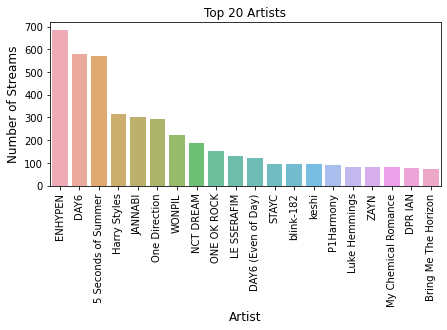

                artistName  noStreams  streamTimeHr
440                ENHYPEN        684     31.462951
359                   DAY6        580     28.959484
18     5 Seconds of Summer        572     30.129983
632           Harry Styles        315     14.387106
708                JANNABI        304     16.571019
1156         One Direction        292     15.272810
1764                WONPIL        221     12.738551
1088             NCT DREAM        188      9.602183
1141           ONE OK ROCK        153      9.640536
890            LE SSERAFIM        129      6.413367
360     DAY6 (Even of Day)        120      6.496103
1342                 STAYC         95      5.031726
1870             blink-182         94      5.065493
1911                 keshi         93      4.503994
1167             P1Harmony         89      4.931583
961          Luke Hemmings         83      5.140488
1848                  ZAYN         80      4.091398
1078   My Chemical Romance         80      4.815214
372         

,artistName,noStreams,streamTimeHr
440,ENHYPEN,684,31.462951
359,DAY6,580,28.959484
18,5 Seconds of Summer,572,30.129983
632,Harry Styles,315,14.387106
708,JANNABI,304,16.571019
1156,One Direction,292,15.272810
1764,WONPIL,221,12.738551
1088,NCT DREAM,188,9.602183
1141,ONE OK ROCK,153,9.640536
890,LE SSERAFIM,129,6.413367


In [40]:
topNartists(df, 20)

So, for the first half of 2022 I listen to **ENHYPEN** the most with total number of streams **684 times** a.k.a **31,5 hours**! 😲

In [41]:
topNtracks(df, 10)

Top 10 Tracks


,trackName,artistName,noStreams,streamTimeHr
1330,Forget Me Not,ENHYPEN,157,8.508853
643,COMPLETE MESS,5 Seconds of Summer,82,4.206428
314,As It Was,Harry Styles,62,2.797469
3039,Polaroid Love,ENHYPEN,50,2.512811
521,Blessed-Cursed,ENHYPEN,43,2.021916
3819,Take My Hand,5 Seconds of Summer,42,2.455573
4402,Wherever you are,ONE OK ROCK,41,3.132294
3208,Right Through Me,DAY6 (Even of Day),41,2.216649
113,A Man Without Love,Engelbert Humperdinck,40,1.836449
131,A journey,WONPIL,39,2.121079


Meanwhile the track that I listen to the most is **Forget Me Not by ENHYPEN** which I listen to for **157 times** or **8,5 hours**!

Then, using `filterByArtist()` function I can see every tracks that I've played from the artist I selected. Let's take a look at one of my favorite singer, Harry Styles.

In [43]:
filterByArtist('Harry Styles')

,noStreams,streamTimeHr
trackName,,
As It Was,62,2.797469
Daylight,24,1.065154
Boyfriends,22,0.981991
Satellite,21,1.078025
Music For a Sushi Restaurant,21,0.738379
Love Of My Life,21,1.027072
Keep Driving,20,0.683747
Grapejuice,20,0.902906
Late Night Talking,18,0.718590


Out of every Harry Styles songs that I listen to turns out I listen to As It Was the most with total of 62 streams. Indeed, who doesn't love As It Was by Harry Styles 🙌🏻

Here's what it looks like for another artist!

In [45]:
filterByArtist('JANNABI')

,noStreams,streamTimeHr
trackName,,
for lovers who hesitate,33,2.400998
GRIPPIN’THEGREEN,21,1.077636
summerfallwinter sprinG.,21,1.034439
LADYBIRD,18,0.977499
A Ballad of Non Le Jon,12,0.603722
...,...,...
The moon,1,0.066111
Like when we first met,1,0.056667
May I Laugh,1,0.047222


I can also see the number of streams of specific song with `noStreamsTrack()` function:

In [50]:
noStreamsTrack('COMPLETE MESS', '5 Seconds of Summer')

[82]

I played COMPLETE MESS by 5 Seconds of Summer 82 times in the first half of 2022.

---

Reference
* [EDA Spotify Personal Data on Medium](https://medium.com/data-folks-indonesia/eda-spotify-personal-data-explore-spotify-personal-data-4a4d1665e6a5)
* [Spotistat by anthonio9 on Github](https://github.com/anthonio9/Spotistat)